In [52]:
import pandas as pd
import matplotlib.pyplot as plt

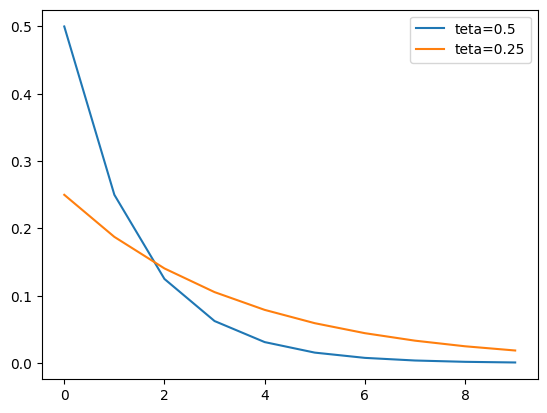

In [53]:
teta1 = 0.5
teta2 = 0.25

plt.plot([teta1*(1-teta1)**i for i in range(10)], label='teta=0.5')
plt.plot([teta2*(1-teta2)**i for i in range(10)], label='teta=0.25')
plt.legend()

In [54]:
df = pd.read_excel("Precios_y_Dinero.xlsx").rename({'M ': 'M'}, axis=1)
df.head()

,MMYY,IPC,M,M_en_ARS
0,2003-01-01,100.000000,100.000000,29609.920333
1,2003-02-01,100.566796,99.359830,29420.366429
2,2003-03-01,101.155116,102.628052,30388.084290
3,2003-04-01,101.212513,104.258927,30870.985333
4,2003-05-01,100.817908,111.804321,33105.170323


#### 1.

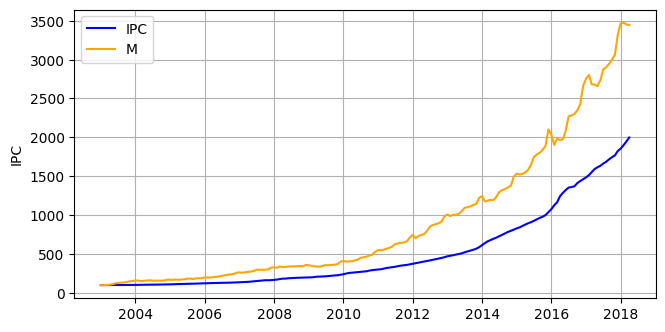

In [55]:
plt.figure(figsize=(10*.75, 5*.75))
plt.plot(df['MMYY'], df['IPC'], label='IPC', color='blue')
plt.plot(df['MMYY'], df['M'], label='M', color='orange')
plt.ylabel('IPC')
plt.legend()
plt.grid()
plt.show()

#### 2.

In [56]:
# Test of Dickey-Fuller
from statsmodels.tsa.stattools import adfuller

In [57]:
# No rechazo: evidencia de no estacionariedad
y = df['IPC'].dropna()
adf = adfuller(y, regression='ct', autolag='AIC')  # 'c' si solo intercepto; 'ct' si hay tendencia
print(adf[0], adf[1])  # estadístico, p-valor

4.5635100465832945 1.0


In [58]:
# No rechazo: la serie diferenciada no es de orden 1
df['delta_1'] = df['IPC'].diff()

result = adfuller(df['delta_1'].dropna())
print(f"ADF Statistic: {result[0]}")
print(f"p-value: {result[1]}")
print(f"Critical Values: {result[4]}")

ADF Statistic: 0.3270847887660057
p-value: 0.9785535607817415
Critical Values: {'1%': np.float64(-3.4685016947910636), '5%': np.float64(-2.8782983668563396), '10%': np.float64(-2.57570415906989)}


In [59]:
# Rechazo: la serie es estacionaria de orden 2
df['delta_2'] = df['delta_1'].diff()

result = adfuller(df['delta_2'].dropna())
print(f"ADF Statistic: {result[0]}")
print(f"p-value: {result[1]}")
print(f"Critical Values: {result[4]}")

ADF Statistic: -7.368282328173164
p-value: 9.113361917991686e-11
Critical Values: {'1%': np.float64(-3.4685016947910636), '5%': np.float64(-2.8782983668563396), '10%': np.float64(-2.57570415906989)}


#### 4.

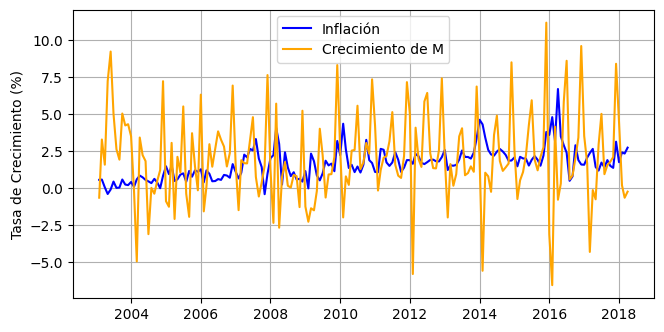

In [60]:
df['inflacion'] = (df['IPC'] - df['IPC'].shift(1)) / df['IPC'].shift(1) * 100
df['crec_m'] = (df['M'] - df['M'].shift(1)) / df['M'].shift(1) * 100

plt.figure(figsize=(10*.75, 5*.75))
plt.plot(df['MMYY'], df['inflacion'], label='Inflación', color='blue')
plt.plot(df['MMYY'], df['crec_m'], label='Crecimiento de M', color='orange')
plt.ylabel('Tasa de Crecimiento (%)')
plt.legend()
plt.grid()
plt.show()

In [61]:
# Rechazo: evidencia de estacionariedad
y = df['inflacion'].dropna()
adf = adfuller(y, regression='c', autolag='AIC')  # 'c' si solo intercepto; 'ct' si hay tendencia
print(adf[0], adf[1])  # estadístico, p-valor

-4.457970592047427 0.000234039663641465


In [62]:
# Rechazo: evidencia de estacionariedad
y = df['crec_m'].dropna()
adf = adfuller(y, regression='c', autolag='AIC')  # 'c' si solo intercepto; 'ct' si hay tendencia
print(adf[0], adf[1])  # estadístico, p-valor

-3.1372591600944184 0.023915925664001258


#### 5.

PACF:

* Corte claro tras el rezago 1 → sugiere un componente AR(1) en la serie de inflación.

* Es decir, la inflación actual depende directamente de la inflacion anterior, pero no de rezagos más lejanos una vez controlado aquel.

ACF:

* Decaimiento lento durante ~10–15 rezagos → es consistente con la presencia de términos AR (porque un AR puro produce ACF que decae gradualmente).

* Si fuera MA puro, la ACF se cortaría en un rezago específico.

#### CONCLUSION: El patrón conjunto (PACF cortando en 1, ACF decayendo lento) es el clásico de un AR(p) puro, con p≈1.

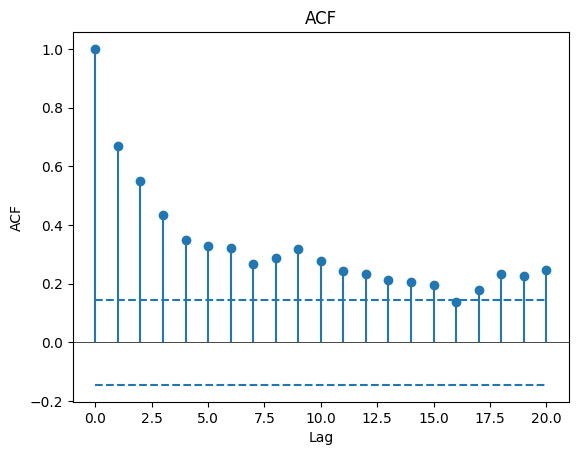

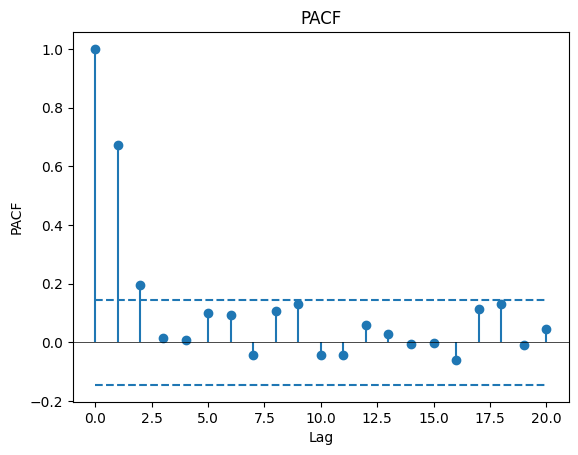

In [12]:
import numpy as np
from statsmodels.tsa.stattools import acf, pacf

# Cálculo de ACF y PACF hasta lag 20
max_lag = 20
acf1 = acf(df['inflacion'].dropna(), nlags=max_lag)
pacf1 = pacf(df['inflacion'].dropna(), nlags=max_lag)

# 3. Calculamos la banda de confianza aproximada al 95%
conf_level = 1.96 / np.sqrt(len(df['inflacion'].dropna()))

# 4. Función para graficar correlogramas con bandas
def plot_correlogram(values, title, ylabel):
    lags = np.arange(len(values))
    plt.figure()
    plt.vlines(lags, 0, values)
    plt.plot(lags, values, 'o')
    plt.hlines([conf_level, -conf_level], 0, max_lag, linestyles='dashed')
    plt.axhline(0, color='black', linewidth=0.5)
    plt.xlabel('Lag')
    plt.ylabel(ylabel)
    plt.title(title)
    plt.show()

# 5. Cuatro gráficos separados
plot_correlogram(acf1,  'ACF',  'ACF')
plot_correlogram(pacf1, 'PACF', 'PACF')

#### 6.
- La variación mensual de M depende directamente de su valor de hace 12 meses.

- Esto es consistente con la impresión de billetes de diciembre para pagar aguinaldos.

- Un modelo AR(12) o MA(12) probablemente capture la dinámica básica.

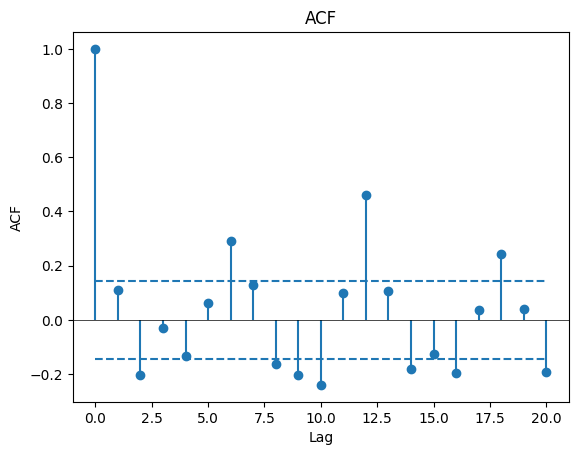

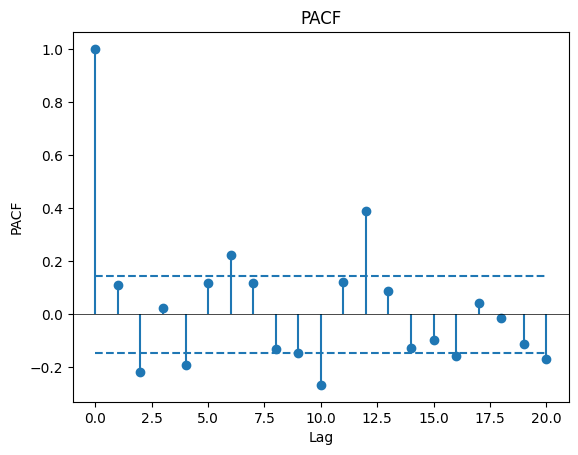

In [13]:
# Cálculo de ACF y PACF hasta lag 20
max_lag = 20
acf1 = acf(df['crec_m'].dropna(), nlags=max_lag)
pacf1 = pacf(df['crec_m'].dropna(), nlags=max_lag)

# 3. Calculamos la banda de confianza aproximada al 95%
conf_level = 1.96 / np.sqrt(len(df['crec_m'].dropna()))

# 4. Función para graficar correlogramas con bandas
def plot_correlogram(values, title, ylabel):
    lags = np.arange(len(values))
    plt.figure()
    plt.vlines(lags, 0, values)
    plt.plot(lags, values, 'o')
    plt.hlines([conf_level, -conf_level], 0, max_lag, linestyles='dashed')
    plt.axhline(0, color='black', linewidth=0.5)
    plt.xlabel('Lag')
    plt.ylabel(ylabel)
    plt.title(title)
    plt.show()

# 5. Cuatro gráficos separados
plot_correlogram(acf1,  'ACF',  'ACF')
plot_correlogram(pacf1, 'PACF', 'PACF')

#### 7.

Paso 1: chequeo que X e Y sean estacionarias (dickey fuller). 

**Si no fuesen estacionarias, entonces o bien:**

1. Son I(0). En cuyo caso, les resto el componente deterministico. Es decir, la nueva serie me queda residuos + intercept.
2. Ambas son I(1). En ese caso, miro los residuos:
- Son estacionarios (estan cointegradas), puedo hacer OLS (con la x e y en niveles).
- NO son estacionarios: diferenciar las series para hacerlas estacionarias o usar un modelo de corrección de errores (ECM) si hay una relación de largo plazo.
3. Son I(i). Miro residuos:
- Son estacionarios (podrían estar cointegradas). Sin embargo, en estos casos es menos probable que haya una relación de largo plazo simple. Debería aplicar diferenciación o usar un modelo ECM si sospechas que hay una relación dinámica.
- Residuos no estacionarios: Esto indica que las series no están cointegradas. No debes usar OLS en niveles. Deberías diferenciar las series y realizar la regresión en las primeras diferencias.
4. Una es I(i) y otra es I(j). Miro residuos:
- Residuos estacionarios: Si los residuos son estacionarios, eso indica que existe una relación de largo plazo (cointegración) entre las series. Sin embargo, en este caso, sería mejor usar un modelo ECM o verificar la cointegración formalmente.
- Residuos no estacionarios: Si las series tienen diferentes órdenes de integración y los residuos no son estacionarios, no puedes usar OLS en niveles. Diferencia las series hasta que ambas sean estacionarias, o usa un enfoque de cointegración (como el test de Johansen o el modelo ECM).

A veces, tengo que hacer ambas cosas (detrending + diferencias).

In [21]:
# Rechazo: evidencia de estacionariedad
y = df['inflacion'].dropna()
adf = adfuller(y, regression='ct', autolag='AIC')  # 'c' si solo intercepto; 'ct' si hay tendencia
print(adf[0], adf[1])  # estadístico, p-valor

# Rechazo: evidencia de estacionariedad
y = df['crec_m'].dropna()
adf = adfuller(y, regression='ct', autolag='AIC')  # 'c' si solo intercepto; 'ct' si hay tendencia
print(adf[0], adf[1])  # estadístico, p-valor

-7.720398146539171 3.163671660812864e-10
-3.67201257822809 0.02426772381487318


Ya que ambas son estacionarias, ajusto la regresión.

In [22]:
import statsmodels.api as sm

df_reg = df[['inflacion', 'crec_m']].dropna()
X = df_reg[['crec_m']]
y = df_reg['inflacion']

X = sm.add_constant(X)

model = sm.OLS(y, X).fit()

print(model.summary())

                            OLS Regression Results                            
Dep. Variable:              inflacion   R-squared:                       0.002
Model:                            OLS   Adj. R-squared:                 -0.004
Method:                 Least Squares   F-statistic:                    0.2784
Date:                Wed, 20 Aug 2025   Prob (F-statistic):              0.598
Time:                        22:52:36   Log-Likelihood:                -268.79
No. Observations:                 183   AIC:                             541.6
Df Residuals:                     181   BIC:                             548.0
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          1.6835      0.095     17.790      0.0

### Chequeo si los residuos estan autocorrelacionados.

OJO: plot de abajo sugiere componente deterministico, es decir, correr el ADF con regression='ct'

ADF dice que los residuos son estacionarios. Además, los gráficos de ACF y PACF muestran un pico del rezago 1 para PACF. Mi siguiente paso sería ajustar una regresión lineal "avisandole" al software que los errores siguen un AR(1). 

OJO2: en stata, habría que mirar primero DFGLS para ver cantidad optima de lags (poniendo trend o notrend según el gráfico de abajo), luego correr ADF con esa cantidad de lags y trend/notrend y ver si rechazamos o no que sea no estacionaria (también confirmar si trend es significativo, caso contrario volver a empezar pero poniendo notrend).

<Axes: title={'center': 'Residuales del modelo'}, ylabel='Residuales'>

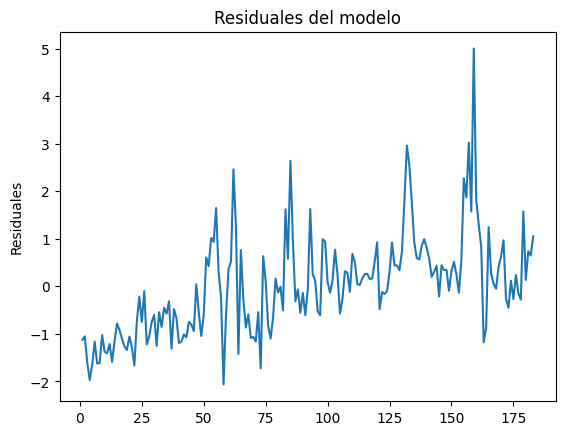

In [17]:
# Sugiere componente deterministico, es decir, correr el ADF con regression='ct'
model.resid.plot(title='Residuales del modelo', ylabel='Residuales')

In [18]:
# Rechazo: evidencia de estacionariedad
y = model.resid
adf = adfuller(y, regression='ct', autolag='AIC')  # 'c' si solo intercepto; 'ct' si hay tendencia
print(adf[0], adf[1])  # estadístico, p-valor

-7.835895529387655 1.7115195586738324e-10


In [34]:
# test de independencia de Durbin-Watson
# Un valor cerca de 2 indica que no hay autocorrelación.
# Un valor < 2 sugiere autocorrelación positiva.
# Un valor > 2 sugiere autocorrelación negativa.

from statsmodels.stats.stattools import durbin_watson
dw_stat = durbin_watson(model.resid)
print(f"Estadístico de Durbin-Watson: {dw_stat}") # Residuos estan correlacionados

Estadístico de Durbin-Watson: 0.6649806231213483


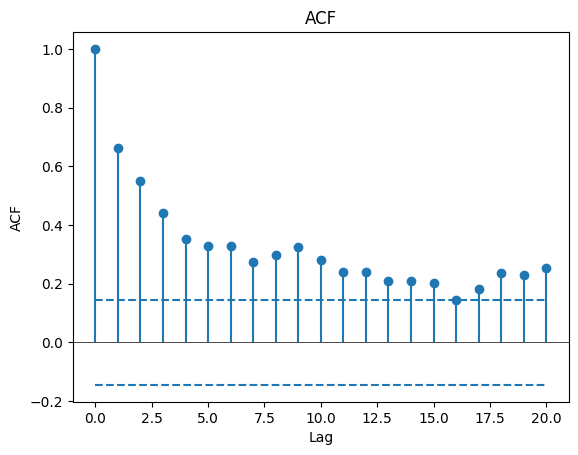

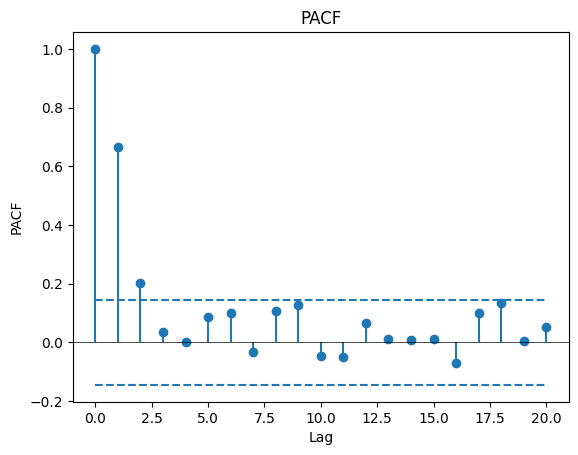

In [19]:
# Cálculo de ACF y PACF hasta lag 20
max_lag = 20
acf1 = acf(model.resid, nlags=max_lag)
pacf1 = pacf(model.resid, nlags=max_lag)

# 3. Calculamos la banda de confianza aproximada al 95%
conf_level = 1.96 / np.sqrt(len(model.resid))

# 4. Función para graficar correlogramas con bandas
def plot_correlogram(values, title, ylabel):
    lags = np.arange(len(values))
    plt.figure()
    plt.vlines(lags, 0, values)
    plt.plot(lags, values, 'o')
    plt.hlines([conf_level, -conf_level], 0, max_lag, linestyles='dashed')
    plt.axhline(0, color='black', linewidth=0.5)
    plt.xlabel('Lag')
    plt.ylabel(ylabel)
    plt.title(title)
    plt.show()

# 5. Cuatro gráficos separados
plot_correlogram(acf1,  'ACF',  'ACF')
plot_correlogram(pacf1, 'PACF', 'PACF')

### OLS generalizado

In [40]:
import statsmodels.api as sm
import statsmodels.tsa.api as tsa

# Prepara los datos
df_reg = df[['inflacion', 'crec_m']].dropna()
X = df_reg[['crec_m']]
y = df_reg['inflacion']

# Añadir constante a las variables independientes
# X = sm.add_constant(X)

# Ajuste ARMA(p, q), p=1, q=1 como ejemplo
# Definir el modelo ARMA con la regresión
model = tsa.ARIMA(y, exog=X, order=(1, 0, 0)) 

# Ajustar el modelo
results = model.fit()

# Mostrar el resumen del modelo
print(results.summary())

                               SARIMAX Results                                
Dep. Variable:              inflacion   No. Observations:                  183
Model:                 ARIMA(1, 0, 0)   Log Likelihood                -213.694
Date:                Wed, 20 Aug 2025   AIC                            435.387
Time:                        23:18:59   BIC                            448.225
Sample:                             0   HQIC                           440.591
                                - 183                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          1.6177      0.210      7.685      0.000       1.205       2.030
crec_m         0.0194      0.016      1.236      0.216      -0.011       0.050
ar.L1          0.6776      0.046     14.704      0.0

/opt/homebrew/Caskroom/miniforge/base/envs/env-udesa/lib/python3.13/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
/opt/homebrew/Caskroom/miniforge/base/envs/env-udesa/lib/python3.13/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
/opt/homebrew/Caskroom/miniforge/base/envs/env-udesa/lib/python3.13/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
